poisson, burst, filter_CNN의 인코더 통과 결과를 plot으로 간단히 볼 수 있도록 하는 코드.

추가 : TP, TP_learnable도 수행해야 할 듯,,

In [1]:
# 사전 변수
models_dirs = ['/home/hschoi/data/leehyunwon/ECG-SNN/SNN_MLP_ver6_poisson_2024-12-27-13-02-25_fold1_lastEpoch.pt',
'/home/hschoi/data/leehyunwon/ECG-SNN/SNN_MLP_ver6_burst_2024-12-27-13-02-29_fold1_lastEpoch.pt',
'/home/hschoi/data/leehyunwon/ECG-SNN/SNN_MLP_ver6_filter_CNN_IF_2024-12-27-13-26-50_fold1_lastEpoch.pt',
'/home/hschoi/data/leehyunwon/ECG-SNN/ver6/SNN_MLP_ver6_TP_original_2024-12-27-14-32-47_fold1_lastEpoch.pt',
'/home/hschoi/data/leehyunwon/ECG-SNN/ver6/SNN_MLP_ver6_TP_learnable_2024-12-29-21-57-05_fold1_lastEpoch.pt']

configs_dirs = ['/home/hschoi/data/leehyunwon/ECG-SNN/SNN_MLP_ver6_poisson_2024-12-27-13-02-25_fold1_config.json',
                '/home/hschoi/data/leehyunwon/ECG-SNN/SNN_MLP_ver6_burst_2024-12-27-13-02-29_fold1_config.json',
                '/home/hschoi/data/leehyunwon/ECG-SNN/SNN_MLP_ver6_filter_CNN_IF_2024-12-27-13-26-50_fold1_config.json',
                '/home/hschoi/data/leehyunwon/ECG-SNN/ver6/SNN_MLP_ver6_TP_original_2024-12-27-14-32-47_fold1_config.json',
                '/home/hschoi/data/leehyunwon/ECG-SNN/ver6/SNN_MLP_ver6_TP_learnable_2024-12-29-21-57-05_fold1_config.json']

selection_num = 4 # 일단 이중에 하나씩 뽑아서 결과 보기
# 0 : poisson, 1 : burst, 2 : filter_CNN, 3 : TP_original, 4 : TP_learnable
selection_name = 'poisson' if selection_num == 0 else 'burst' if selection_num == 1 else 'filter_CNN' if selection_num == 2 else 'TP_original' if selection_num == 3 else 'TP_learnable'

current_model_dir = models_dirs[selection_num] 
current_config_dir = configs_dirs[selection_num]

savefile_name = f'encoding_result_{selection_name}.svg'

In [2]:
# Imports
import os
import torch
import numpy as np # .npy 읽기용
import pandas as pd # csv 읽기용
import torch.nn.functional as F  # 일부 활성화 함수 등 파라미터 없는 함수에 사용
import torchvision.datasets as datasets  # 일반적인 데이터셋; 이거 아마 MIT-BIH로 바꿔야 할 듯?
import torchvision.transforms as transforms  # 데이터 증강을 위한 일종의 변형작업이라 함
from torch import optim  # SGD, Adam 등의 옵티마이저(그래디언트는 이쪽으로 가면 됩니다)
from torch.optim.lr_scheduler import CosineAnnealingLR # 코사인스케줄러(옵티마이저 보조용)
from torch import nn, Tensor  # 모든 DNN 모델들
from torch.utils.data import (DataLoader, Dataset)  # 미니배치 등의 데이터셋 관리를 도와주는 녀석
from tqdm import tqdm  # 진행도 표시용
import torchmetrics # 평가지표 로깅용
from typing import Callable # 람다식
from torch.utils.tensorboard import SummaryWriter # tensorboard 기록용
import time # 텐서보드 폴더명에 쓸 시각정보 기록용
import random # 랜덤시드 고정용

# 여긴 인코더 넣을때 혹시 몰라서 집어넣었음
import sys
import os
import json
import numpy as np

# 얘는 SNN 학습이니까 당연히 있어야겠지? 특히 SNN 모델을 따로 만드려는 경우엔 뉴런 말고도 넣을 것이 많다.
# import spikingjelly.activation_based as jelly
from spikingjelly.activation_based import neuron, encoding, functional, surrogate, layer
from sklearn.model_selection import KFold # cross-validation용

# 히스토그램 찍기 위한 플롯
import matplotlib
import matplotlib.pyplot as plt


# json 읽어다가 반환(파일경로 없으면 에러띄우기)
def loadJson() : 
    with open(current_config_dir, 'r') as f:
        print("config.json파일 읽기 성공!")
        return json.load(f)
        
# 파일 읽어들이고 변수들 할당하기
json_data = loadJson()
cuda_gpu = json_data['cuda_gpu']
model_name = json_data['model_name']
num_classes = json_data['num_classes']
num_encoders = json_data['num_encoders'] # 편의상 이녀석을 MIT-BIH 길이인 187로 지정하도록 한다.
early_stop = json_data['early_stop']
early_stop_enable = json_data['early_stop_enable']
learning_rate = json_data['init_lr']
batch_size = json_data['batch_size']
num_epochs = json_data['num_epochs']
train_path = json_data['train_path']
test_path = json_data['test_path']
class_weight = json_data['class_weight']
encoder_min = json_data['encoder_min']
encoder_max = json_data['encoder_max']
hidden_size = json_data['hidden_size']
hidden_size_2 = json_data['hidden_size_2']
scheduler_tmax = json_data['scheduler_tmax']
scheduler_eta_min = json_data['scheduler_eta_min']
encoder_requires_grad = json_data['encoder_requires_grad']

random_seed = json_data['random_seed']
checkpoint_save = json_data['checkpoint_save']
checkpoint_path = json_data['checkpoint_path']
threshold_value = json_data['threshold_value']
reset_value_residual = json_data['reset_value_residual']
need_bias = json_data['need_bias']
k_folds = json_data['k_folds']

# poisson, burst
if selection_num == 0 or selection_num == 1 : 
    timestep = json_data['timestep']

# burst
if selection_num == 1 : 
    burst_beta = json_data['burst_beta']
    burst_init_th = json_data['burst_init_th']

# filter_CNN
if selection_num == 2 : 
    encoder_type = json_data['encoder_type']
    encoder_tp_iter_repeat = json_data['encoder_tp_iter_repeat']
    encoder_filter_kernel_size = json_data['encoder_filter_kernel_size']
    encoder_filter_stride = json_data['encoder_filter_stride']
    encoder_filter_padding = json_data['encoder_filter_padding']
    encoder_filter_channel_size = json_data['encoder_filter_channel_size']

# TP, TP_learnable은 추가 변수 없음


# Cuda 써야겠지?
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"  # GPU 번호별로 0번부터 나열
os.environ["CUDA_VISIBLE_DEVICES"]= str(cuda_gpu)  # 상황에 맞춰 변경할 것
device = "cuda" if torch.cuda.is_available() else "cpu" # 연산에 GPU 쓰도록 지정
print("Device :" + device) # 확인용
# input() # 일시정지용


# 랜덤시드 고정
seed = random_seed
deterministic = True
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
if deterministic:
	torch.backends.cudnn.deterministic = True
	torch.backends.cudnn.benchmark = False



# 데이터 가져오는 알맹이 클래스
class MITLoader_MLP_binary(Dataset):

    def __init__(self, csv_file, transforms: Callable = lambda x: x) -> None:
        super().__init__()
        self.annotations = pd.read_csv(csv_file).values
        self.transforms = transforms

    def __len__(self):
        return self.annotations.shape[0]

    def __getitem__(self, item):
        signal = self.annotations[item, :-1]
        signal = torch.from_numpy(signal).float()
        if self.transforms : 
            signal = self.transforms(signal)
        
        label = int(self.annotations[item, -1])
        if label > 0:
            label = 1  # 1 이상인 모든 값은 1로 변환(난 이진값 처리하니깐)

        return signal, torch.tensor(label).long()


# 포아송 모델
class SNN_MLP(nn.Module):
    def __init__(self, num_classes, num_encoders, hidden_size, hidden_size_2, threshold_value, bias_option, reset_value_residual):
        super().__init__()
        
        # SNN 리니어 : 인코더 입력 -> 히든
        self.hidden = nn.Sequential(
            layer.Linear(num_encoders, hidden_size, bias = bias_option), # bias는 일단 기본값 True로 두기
            neuron.IFNode(surrogate_function=surrogate.ATan(), v_reset= None if reset_value_residual else 0.0, v_threshold=threshold_value),
            )
        
        # SNN 리니어 : 히든2 -> 출력
        self.layer = nn.Sequential(
            layer.Linear(hidden_size, num_classes, bias = bias_option), # bias는 일단 기본값 True로 두기
            neuron.IFNode(surrogate_function=surrogate.ATan(), v_reset= None if reset_value_residual else 0.0, v_threshold=threshold_value),
            )

    def forward(self, x: torch.Tensor):
        x = self.hidden(x)
        return self.layer(x)
    
# burst 모델
class SNN_Burst(nn.Module):
    def __init__(self, num_classes, num_encoders, hidden_size, hidden_size_2, threshold_value, bias_option, reset_value_residual):
        super().__init__()
        
        # SNN 리니어 : 인코더 입력 -> 히든
        self.hidden = nn.Sequential(
            layer.Linear(num_encoders, hidden_size, bias=bias_option), # bias는 일단 기본값 True로 두기
            neuron.IFNode(surrogate_function=surrogate.ATan(), v_reset= None if reset_value_residual else 0.0, v_threshold=threshold_value),
            )
        
        # SNN 리니어 : 히든2 -> 출력
        self.layer = nn.Sequential(
            layer.Linear(hidden_size, num_classes, bias=bias_option), # bias는 일단 기본값 True로 두기
            neuron.IFNode(surrogate_function=surrogate.ATan(), v_reset= None if reset_value_residual else 0.0, v_threshold=threshold_value),
            )
    
    def forward(self, x: torch.Tensor):
        x = self.hidden(x)
        return self.layer(x)

# 인코딩용 burst 클래스
class BURST(nn.Module):
    def __init__(self, beta=2, init_th=0.0625, device='cuda') -> None:
        super().__init__()
        
        self.beta = beta
        self.init_th = init_th
        self.device = device
        
    def burst_encode(self, data, t):
        if t==0:
            self.mem = data.clone().detach().to(self.device) # 이건 그대로
            self.th = torch.ones(self.mem.shape, device=self.device) * self.init_th # 밖에 있는 코드 가져오느라 이렇게 된듯
            
        self.output = torch.zeros(self.mem.shape).to(self.device) # 0, 1 단위로 보내기 위해 이게 필요(아래 코드에 쓰는 용도)
        
        fire = (self.mem >= self.th) # 발화여부 확인
        self.output = torch.where(fire, torch.ones(self.output.shape, device=self.device), self.output) # 발화됐으면 1, 아니면 0 놓는 녀석
        out = torch.where(fire, self.th, torch.zeros(self.mem.shape, device=self.device)) # 얜 이제 잔차로 리셋하는 원래 동작 위해서 있는 녀석
        self.mem -= out
        
        self.th = torch.where(fire, self.th * self.beta, torch.ones(self.th.shape, device=self.device)*self.init_th) # 연속발화시 2배로 늘리기, 아니면 다시 초기치로 이동

        # 입력값 재설정하고 싶으면 쓰기 : 원본에서도 이건 그냥 있었으니 냅둘 것
        if self.output.max() == 0:
            self.mem = data.clone().detach().to(self.device)
        
        # 반환 : 스파이크 뜬 그 출력용 녀석 내보내기
        return self.output.clone().detach()
    
    def forward(self, input:Tensor, t:int) -> Tensor:
        return self.burst_encode(input, t)


# filter_CNN 모델
class SNN_filter_CNN(nn.Module):
    def __init__(self, num_classes, hidden_size, hidden_size_2, out_channels, kernel_size, stride, padding, threshold_value, bias_option, reset_value_residual):
        super().__init__()
        
        # CNN 인코더 필터
        self.cnn_encoders = nn.Conv1d(in_channels=1, out_channels=out_channels, kernel_size=kernel_size,
                                      stride=stride, padding=padding, bias=bias_option) # 여기도 bias가 있다 함
        
        # CNN 인코더 IF뉴런
        self.cnn_IF_layer = neuron.IFNode(surrogate_function=surrogate.ATan(),v_reset= None if reset_value_residual else 0.0, v_threshold=threshold_value)
        
        # SNN 리니어 : 인코더 입력 -> 히든
        self.hidden = nn.Sequential(
            layer.Linear(out_channels, hidden_size, bias=bias_option), # bias는 일단 기본값 True로 두기
            neuron.IFNode(surrogate_function=surrogate.ATan(),v_reset= None if reset_value_residual else 0.0, v_threshold=threshold_value),
            )

        # SNN 리니어 : 히든 -> 출력
        self.layer = nn.Sequential(
            layer.Linear(hidden_size, num_classes, bias=bias_option), # bias는 일단 기본값 True로 두기
            neuron.IFNode(surrogate_function=surrogate.ATan(),v_reset= None if reset_value_residual else 0.0, v_threshold=threshold_value),
            )

    def forward(self, x: torch.Tensor):
        results = 0.
        x = x.unsqueeze(1)
        x = self.cnn_encoders(x)
        timestep_size = x.shape[2]
        # 근데 이제 이렇게 바꾼 데이터는 (배치, 채널, 출력크기) 만큼의 값을 갖고 있으니 여기서 나온 값들을 하나씩 잘라서 다음 레이어로 넘겨야 한다.
        for i in range(timestep_size) : 
            x_slice = x[:,:,i].squeeze() # 이러면 출력크기 차원이 사라지고 (배치, 채널)만 남겠지?
            x_slice = self.cnn_IF_layer(x_slice) # CNN 필터 이후 IF 레이어 거치기
            x_slice = self.hidden(x_slice)
            x_slice = self.layer(x_slice)
            results += x_slice  # 결과를 리스트에 저장(출력발화값은 전부 더하는 식으로)
        return results / timestep_size


# TP, TP_learnable 모델 : 이 둘의 구조는 동일함
class SNN_TP_series(nn.Module):
    def __init__(self, num_classes, hidden_size, hidden_size_2, threshold_value, bias_option, reset_value_residual):
        super().__init__()
        
        # SNN 인코더 : 채널 크기만큼 확장하기
        self.encoder = nn.Sequential(
            # layer.Flatten(),
            layer.Linear(1, hidden_size, bias=bias_option), # bias는 일단 기본값 True로 두기
            neuron.IFNode(surrogate_function=surrogate.ATan(),v_reset= None if reset_value_residual else 0.0, v_threshold=threshold_value),
            )

        # SNN 리니어 : 인코더 출력 -> 히든
        self.hidden = nn.Sequential(
            # layer.Flatten(),
            layer.Linear(hidden_size, hidden_size_2, bias=bias_option), # bias는 일단 기본값 True로 두기
            neuron.IFNode(surrogate_function=surrogate.ATan(),v_reset= None if reset_value_residual else 0.0, v_threshold=threshold_value),
            )
        

        # SNN 리니어 : 히든 -> 출력
        self.layer = nn.Sequential(
            # layer.Flatten(),
            layer.Linear(hidden_size_2, num_classes, bias=bias_option), # bias는 일단 기본값 True로 두기
            neuron.IFNode(surrogate_function=surrogate.ATan(),v_reset= None if reset_value_residual else 0.0, v_threshold=threshold_value),
            )

    def forward(self, x: torch.Tensor):
        results = 0. # for문이 모델 안에 있으므로 밖에다가는 이녀석을 내보내야 함
        # print(x.shape) # (배치크기, 187) 모양임
        
        timestep_size = x.shape[1] # 187 timestep을 만들어야 함
        # 근데 이제 이렇게 바꾼 데이터는 (배치, 출력크기) 만큼의 값을 갖고 있으니 여기서 나온 값들을 하나씩 잘라서 다음 레이어로 넘겨야 한다.
        for i in range(timestep_size) : 
            x_slice = x[:,i].squeeze().unsqueeze(1) # 슬라이스 진행 후 256, 1 크기가 되도록 shape 수정
            x_slice = self.encoder(x_slice)
            x_slice = self.hidden(x_slice)
            x_slice = self.layer(x_slice)
            results += x_slice  # 결과를 리스트에 저장(출력발화값은 전부 더하는 식으로)
        # results = torch.stack(results, dim=0) # 텐서로 바꾸기
        return results / timestep_size





# 모델 로드, 가중치도 같이 진행
if selection_num == 0 : 
    model = SNN_MLP(num_encoders=num_encoders, num_classes=num_classes, hidden_size=hidden_size,
                    hidden_size_2=hidden_size_2, threshold_value=threshold_value, bias_option=need_bias,
                    reset_value_residual=reset_value_residual).to(device)
elif selection_num == 1 : 
    model = model = SNN_Burst(num_encoders=num_encoders, num_classes=num_classes, hidden_size=hidden_size,
                    hidden_size_2=hidden_size_2, threshold_value=threshold_value, bias_option=need_bias,
                    reset_value_residual=reset_value_residual).to(device)
elif selection_num == 2 : 
    model = SNN_filter_CNN(num_classes = num_classes, hidden_size=hidden_size, hidden_size_2=hidden_size_2, 
            out_channels=encoder_filter_channel_size, kernel_size=encoder_filter_kernel_size, 
            stride=encoder_filter_stride, padding=encoder_filter_padding, threshold_value=threshold_value, 
            bias_option=need_bias, reset_value_residual=reset_value_residual).to(device=device)
elif selection_num == 3 or selection_num == 4 :
    model = SNN_TP_series(num_classes = num_classes, hidden_size=hidden_size, hidden_size_2=hidden_size_2, threshold_value=threshold_value, 
                bias_option=need_bias, reset_value_residual=reset_value_residual).to(device=device)

checkpoint = torch.load(current_model_dir)
model.load_state_dict(checkpoint["model_state_dict"])

# 데이터도 여기서 로드
test_dataset = MITLoader_MLP_binary(csv_file=test_path)
test_loader = DataLoader(dataset=test_dataset, batch_size=1, shuffle=True, drop_last=True)

# 인코더 지정 : 각자 상황에 따라 지정
# Poisson : 어디서 선언하든 상관없음
# Burst : 한 배치 안에서 소환하여 자동 초기화 유도해야 함
# filter_CNN : 모델에 내장됨
# TP, TP_learnable : 모델에 내장됨(첫째 레이어)

2025-06-02 09:01:25.675631: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-06-02 09:01:25.728523: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-06-02 09:01:26.510256: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


config.json파일 읽기 성공!
Device :cuda


In [3]:
# 데이터 로더에서 배치 가져오기
data_iter = iter(test_loader)
for i in range(999) : 
    inputs, labels = next(data_iter)  # 입력 데이터와 라벨

inputs = inputs.to(device)  # GPU로 이동

print(inputs.shape)

torch.Size([1, 187])


In [4]:
# 인코딩 결과를 저장할 리스트
encoded_signals = []

if selection_num == 0:  # Poisson 인코딩
    encoder = encoding.PoissonEncoder()

    for i in range(timestep) : 
        encoded_signals.append(encoder(inputs).cpu().numpy())

elif selection_num == 1:  # Burst 인코딩
    encoder = BURST(beta=burst_beta, init_th=burst_init_th)
    for i in range(timestep):
        encoded_signals.append(encoder(inputs, i).cpu().numpy())

elif selection_num == 2:  # Filter_CNN 인코딩
    with torch.no_grad():
        results = 0.
        x = inputs.unsqueeze(1)
        x = model.cnn_encoders(x)
        print(x.shape)
        timestep_size = x.shape[2]
        # 근데 이제 이렇게 바꾼 데이터는 (배치, 채널, 출력크기) 만큼의 값을 갖고 있으니 여기서 나온 값들을 하나씩 잘라서 다음 레이어로 넘겨야 한다.
        for i in range(timestep_size) : 
            x_slice = x[:,:,i].squeeze() # 이러면 출력크기 차원이 사라지고 (배치, 채널)만 남겠지?
            x_slice = model.cnn_IF_layer(x_slice) # CNN 필터 이후 IF 레이어 거치기
            encoded_signals.append(x_slice.cpu().numpy())

elif selection_num == 3 or selection_num == 4:  # TP, TP_learnable 인코딩
    # 데이터를 단순히 세로로 슬라이스해서 모델에 넣으면 될 듯
    with torch.no_grad():
        timestep_size = inputs.shape[1] # (배치, 타임스텝) 형식일 것이므로 타임스텝만 가져오기
        for i in range(timestep_size):
            x_encoded = model.encoder(inputs[:, i]) # (배치, 1)씩 넣고 인코더가 결과 뱉는거 스택하기
            encoded_signals.append(x_encoded.cpu().numpy())
        

print(np.shape(encoded_signals))
encoded_signal = np.squeeze(encoded_signals)  # 배치에서 1만 줬으므로 큰 상관 없고 여기선 squeeze만 수행 (나중에 배치 추가하면 바뀔수도 있음)
print(np.shape(encoded_signal))

(187, 1024)
(187, 1024)


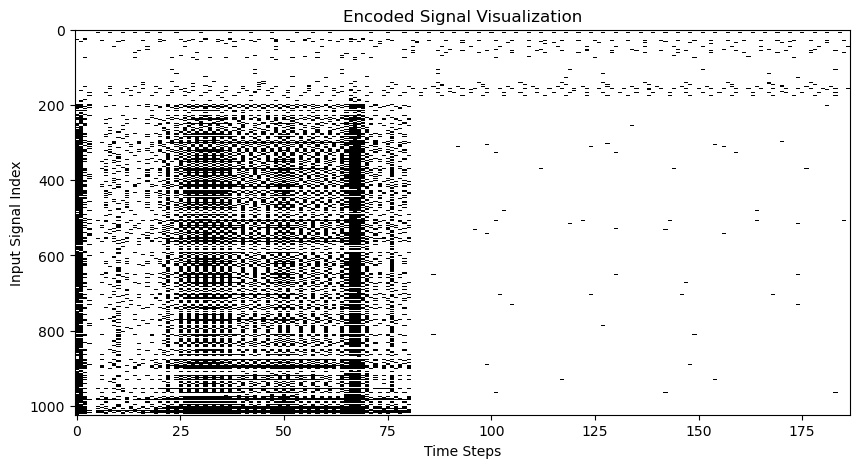

In [5]:
plt.figure(figsize=(10, 5))

# 그래프 데이터 (비트맵 처리)
im = plt.imshow(
    encoded_signal.T,
    aspect='auto',
    cmap='gray_r',
    interpolation='nearest',
    rasterized=True  # 그래프는 비트맵으로 저장
)

# 텍스트 및 축 설정 (벡터 유지)
plt.xlabel("Time Steps")
plt.ylabel("Input Signal Index")
plt.title("Encoded Signal Visualization")

# PDF 저장
plt.savefig(savefile_name, format="svg", bbox_inches="tight", dpi=300)
plt.show()
plt.close()